# Kaggle Competition: EDA

**Team: Random Forest Rangers** (Dmitry Gufranov, Evgenia Amineva, Valeriya Vazhnova)

## Main Questions

- Which 3 features have the highest number of missing values?
- How the price behave over the years?
- Plot the the feature distribution using histograms
- Compute and order the features by their correlation with label
- Add more EDA that will help you understand the data and support your modeling decisions

In [29]:
import numpy as np
import pandas as pd
import datetime

import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [30]:
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter('ignore')

## Loading the data

In [31]:
# loading train data

df = pd.read_csv('./data/train.csv')
df.shape

(1460, 81)

In [32]:
display(df.head())
df.tail()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125
1459,1460,20,RL,75.0,9937,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,147500


## Overview

In [33]:
df.index.is_monotonic, df['Id'].is_monotonic

(True, True)

In [34]:
# no empty columns

df.isnull().all().sum()

0

In [35]:
# no duplicates (even if we disregard id)

df.drop(columns=['Id']).duplicated().sum()

0

In [36]:
# all ids are unique

df['Id'].is_unique

True

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [38]:
# missing values

df.isnull().sum()[df.isnull().sum().gt(0)] / df.shape[0] * 100

LotFrontage     17.739726
Alley           93.767123
MasVnrType       0.547945
MasVnrArea       0.547945
BsmtQual         2.534247
BsmtCond         2.534247
BsmtExposure     2.602740
BsmtFinType1     2.534247
BsmtFinType2     2.602740
Electrical       0.068493
FireplaceQu     47.260274
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
PoolQC          99.520548
Fence           80.753425
MiscFeature     96.301370
dtype: float64

## Which 3 features have the highest number of missing values?

In [39]:
# cols with the highest number of missing values (% missing)

df.isnull().sum()[df.isnull().sum().gt(0)].nlargest(3) / df.shape[0] * 100

PoolQC         99.520548
MiscFeature    96.301370
Alley          93.767123
dtype: float64

## How the price behave over the years?

In [40]:
# combining month and year

df['SaleDate'] = df.apply(lambda x: datetime.date(x['YrSold'], x['MoSold'], 1), axis=1)

In [41]:
# how did price behave over the years

month_price = df.groupby('SaleDate')['SalePrice'].mean().to_frame('AvgPrice')


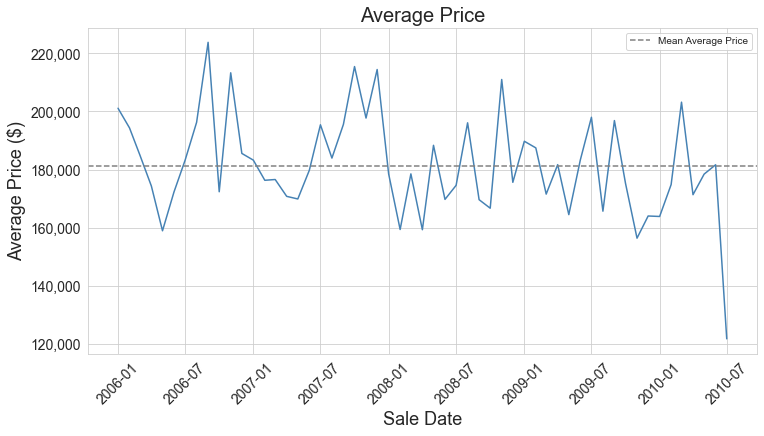

In [42]:
sns.set_style("whitegrid")

plt.figure(figsize=(12, 6))
sns.lineplot(data=month_price, x=month_price.index, y='AvgPrice', color='steelblue')
plt.axhline(y=month_price['AvgPrice'].mean(), linestyle='--', color='grey', label='Mean Average Price')

plt.title('Average Price', fontsize=20)
plt.xlabel('Sale Date', fontsize=18)
plt.ylabel('Average Price ($)', fontsize=18)
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.legend()
plt.show();

Sale Price fluctuates heavily from month to month. We can also notice some seasonality patterns: in the beginning of each year (approx. until May) average prices decline, they reach their peak hight in September–November, but usually drop again by December. 

But it's more interesting to check the seasonality by the number of sales, where the trend is the opposite: autumn has significant drop in housing sales, so each observation gains more weight (and thus raises the average price). Peak sales are always in June-July (possibly before the beginning of the school year).

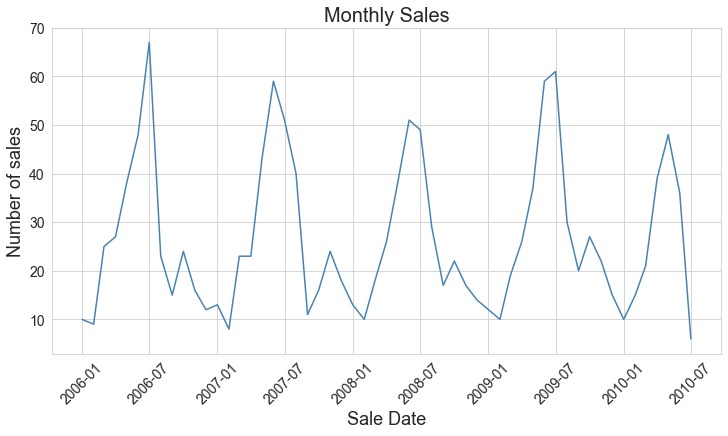

In [43]:
month_sale = df.groupby('SaleDate').size().to_frame('Sales')

plt.figure(figsize=(12, 6))
sns.lineplot(data=month_sale, x=month_sale.index, y='Sales', color='steelblue')
plt.title('Monthly Sales', fontsize=20)
plt.xlabel('Sale Date', fontsize=18)
plt.ylabel('Number of sales', fontsize=18)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.show();

In [44]:
# how did price behave over the years

year_price = df.groupby('YrSold')['SalePrice'].mean().to_frame('AvgPrice')
year_price['YearOnYearChange'] = year_price['AvgPrice'].pct_change()
year_price['ChangeLabel'] = year_price['YearOnYearChange'].map(lambda x: 
                                                               f'+{x :.0%}' if x > 0 else f'{x :.0%}')


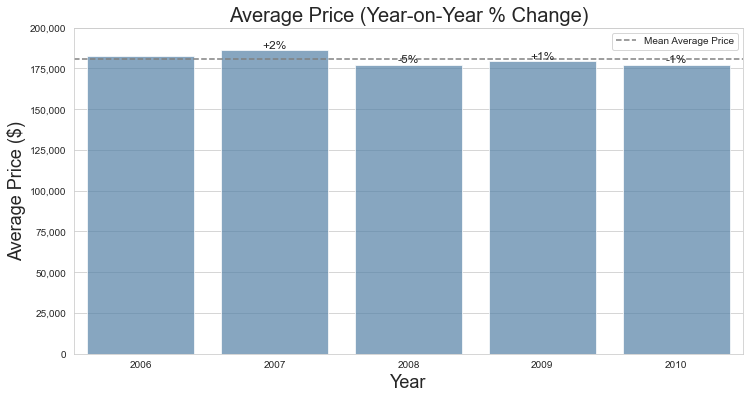

In [45]:
# Create the plot
plt.figure(figsize=(12, 6))
sns.barplot(data=year_price, x=year_price.index, y='AvgPrice', color='steelblue', alpha=0.7)
plt.axhline(y=year_price['AvgPrice'].mean(), linestyle='--', color='grey', label='Mean Average Price')

for i, label in enumerate(year_price['ChangeLabel'][1:], start=1):
    plt.text(i, year_price['AvgPrice'].iloc[i], label, ha='center', va='bottom', fontsize=12)

plt.title('Average Price (Year-on-Year % Change)', fontsize=20)
plt.xlabel('Year', fontsize=18)
plt.ylabel('Average Price ($)', fontsize=18)
plt.ylim(0, 200000)
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.legend()
plt.show();

Our data covers the span of 5 years (2006-2010). Over that time average prices were pretty stable, centered around $180K, with with year-on-year variations under 5%.

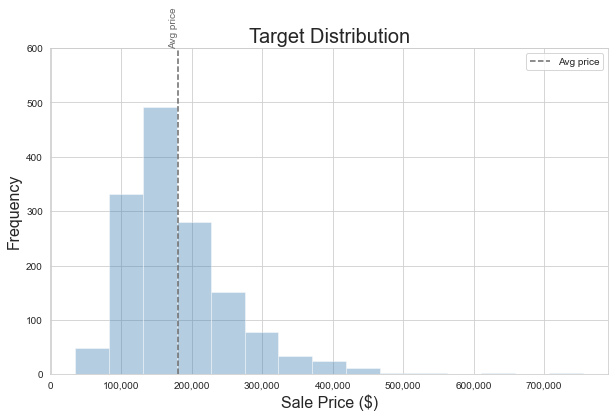

In [46]:
# overall distribution

plt.figure(figsize=(10, 6))
sns.distplot(df['SalePrice'], bins=15, color='steelblue', kde=False)
plt.axvline(x=df['SalePrice'].mean(), linestyle='--', color='dimgrey', label='Avg price')
plt.text(df['SalePrice'].mean(), 600, 'Avg price', rotation=90, va='bottom', ha='right', color='dimgrey')
plt.title('Target Distribution', fontsize=20)
plt.xlabel('Sale Price ($)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.ylim(0, 600)
plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.legend()
plt.show();

In [47]:
display(df['SalePrice'].describe())
print(f'95th percentile: {np.percentile(df["SalePrice"], 95) :,.0f}')
print(f'Skewness: {df["SalePrice"].skew() :,.2f}')
print(f'Kurtosis: {df["SalePrice"].kurtosis() :,.2f}')

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

95th percentile: 326,100
Skewness: 1.88
Kurtosis: 6.54


While overall our target (Sale Price) is distributed normally, its distribution is heavily skewed to the right with very high prices as outliers. We can see it from high skewness coefficient (>1), high positive kurtosis indicating heavy tails, as well as the histogram itself.

## Feature distribution

In [48]:
# numeric features (excluding ID, date sold & target)
numeric_features = df.select_dtypes(include=['int', 'float']).columns[1:-4]

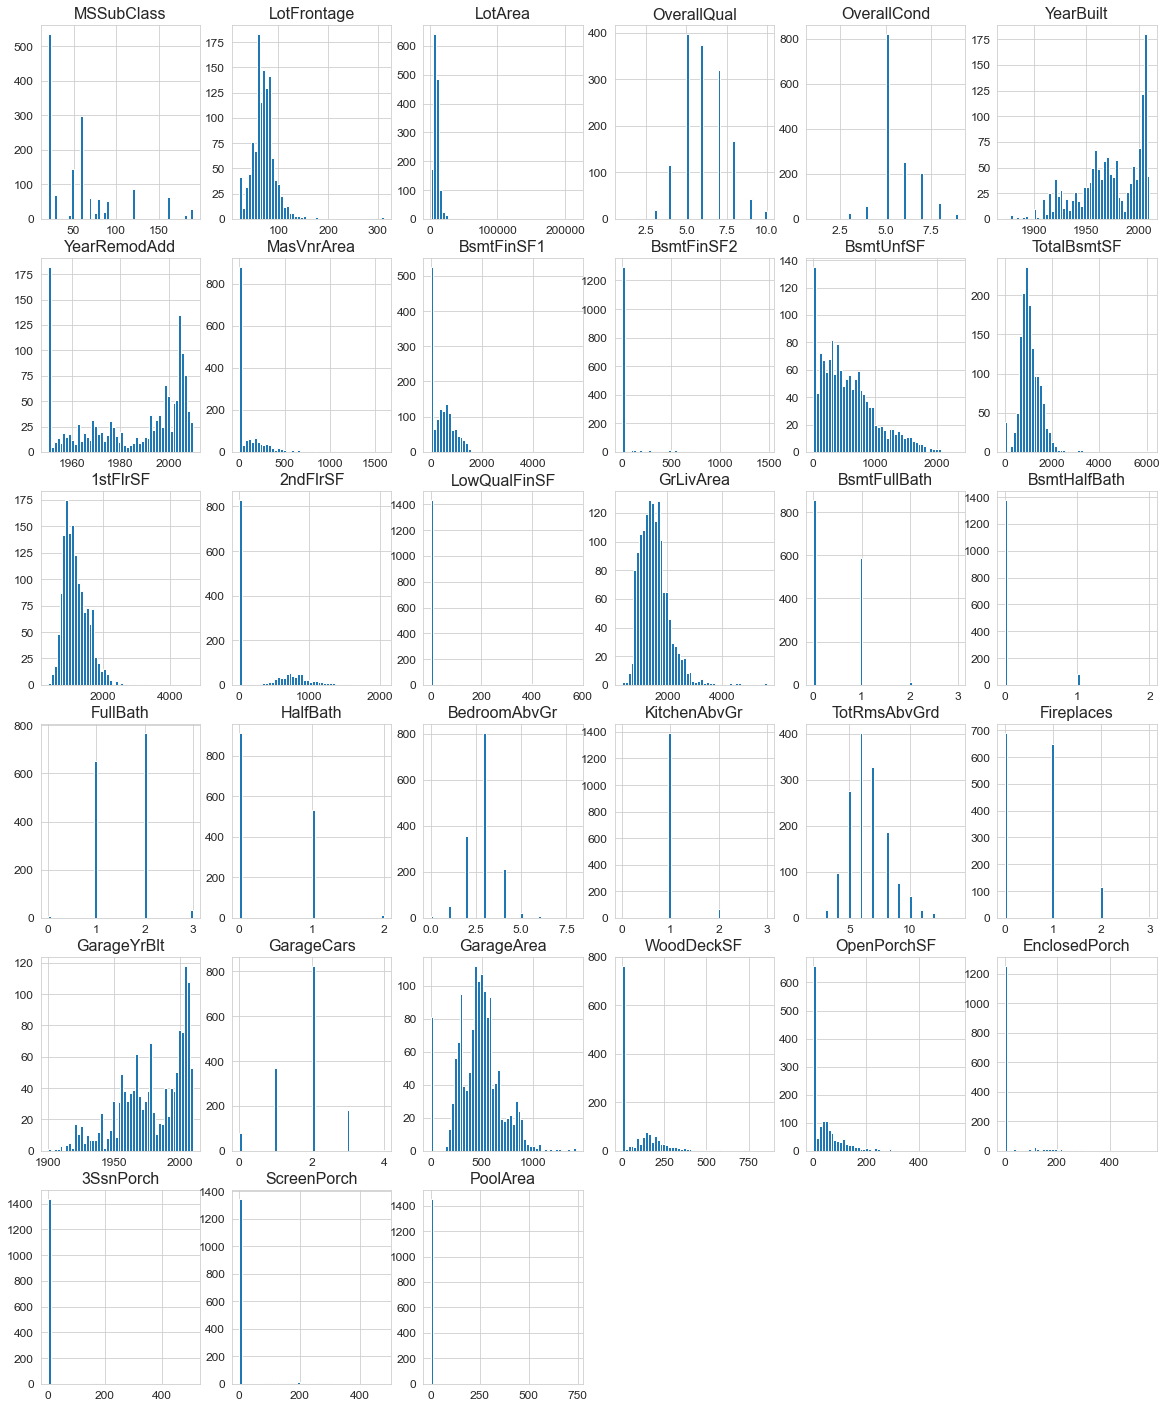

In [49]:
fig, axes = plt.subplots(6, 6, figsize=(20, 25))
axes_flat = axes.flatten()

for i, n in enumerate(numeric_features):
    axes_flat[i].hist(df[n], bins=50)
    axes_flat[i].set_title(f'{n}', fontsize=16)
    axes_flat[i].tick_params(axis='both', labelsize=12)
    

for j in range(len(numeric_features), 6 * 6):
    axes_flat[j].axis('off')

plt.show();


In [50]:
# categorical features (excluding SaleDate that we created)

cat_features = df.select_dtypes(include='object').columns[:-1]

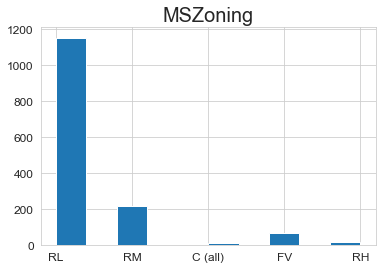

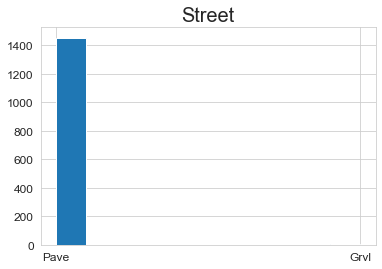

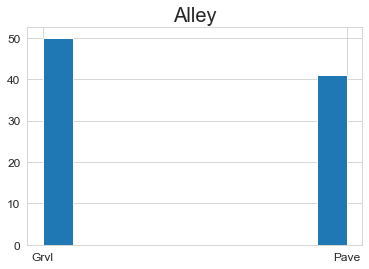

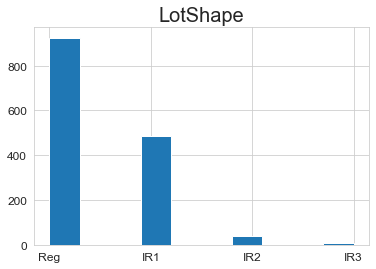

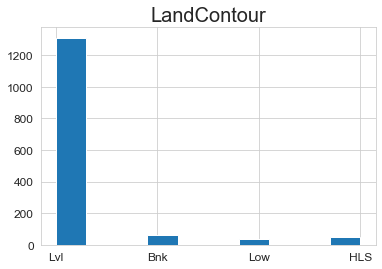

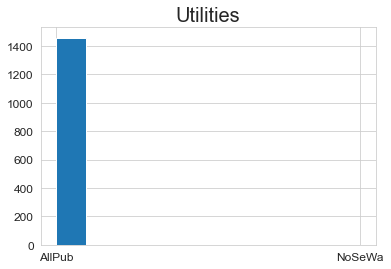

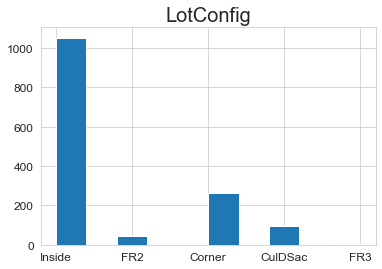

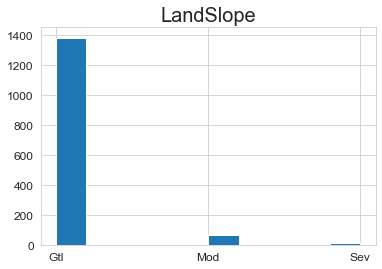

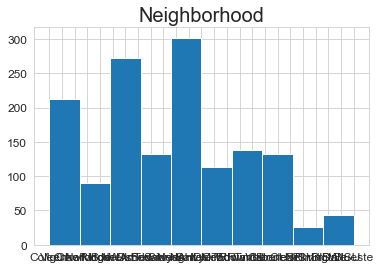

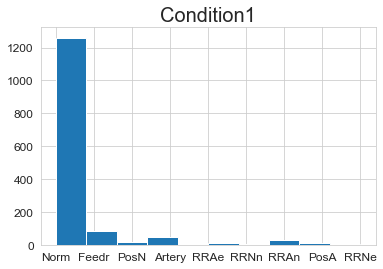

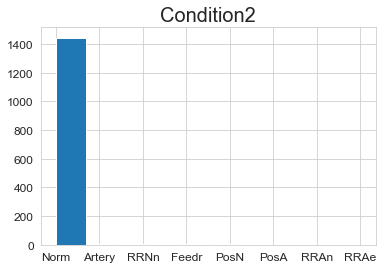

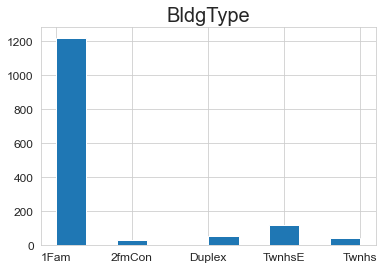

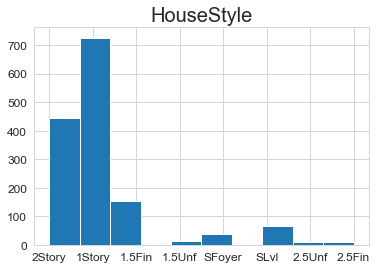

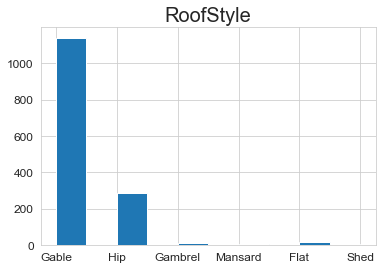

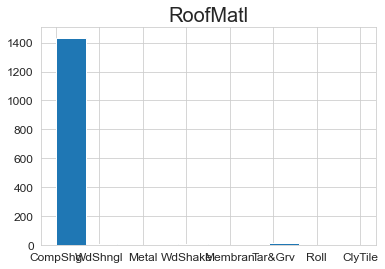

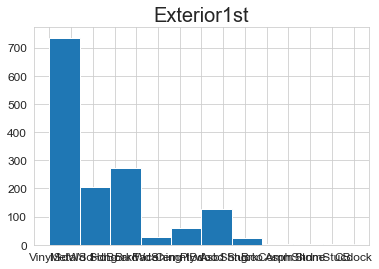

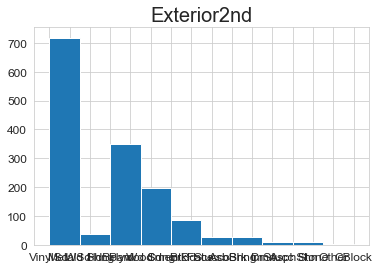

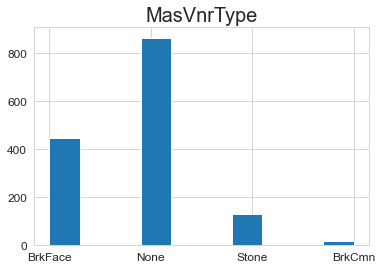

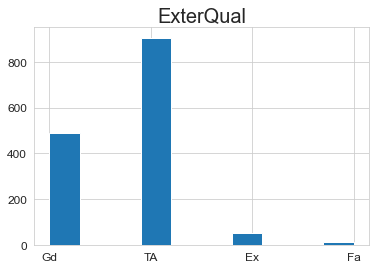

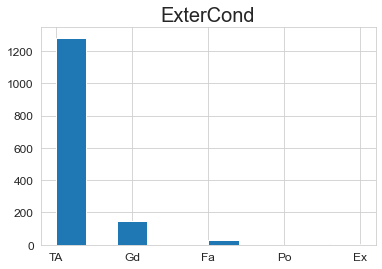

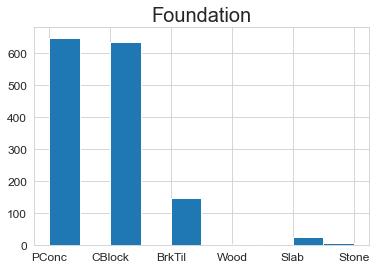

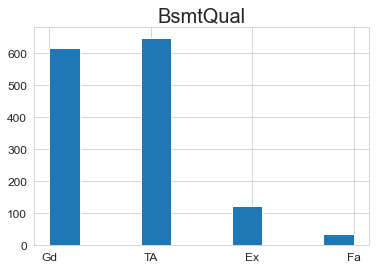

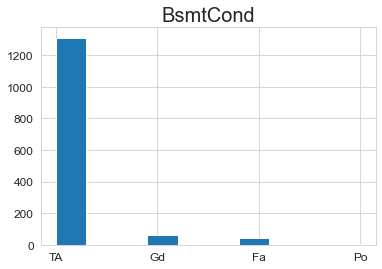

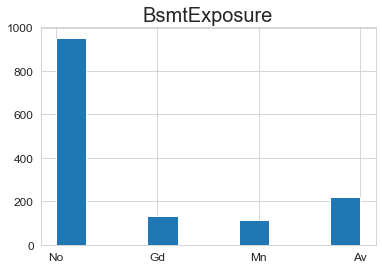

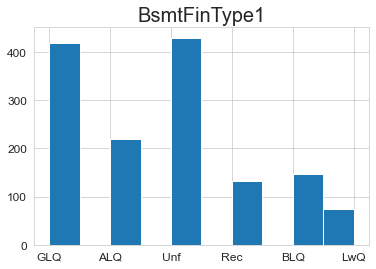

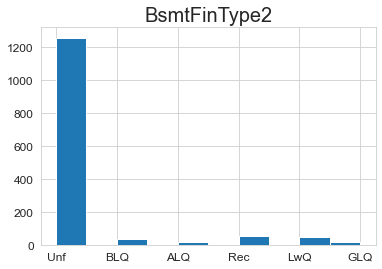

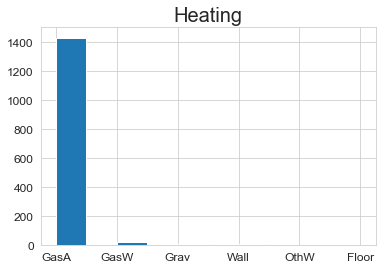

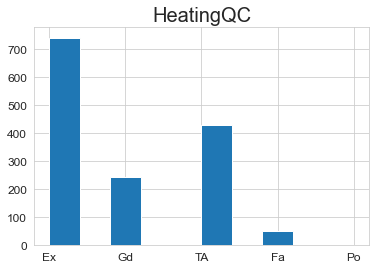

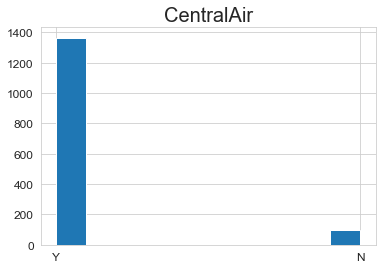

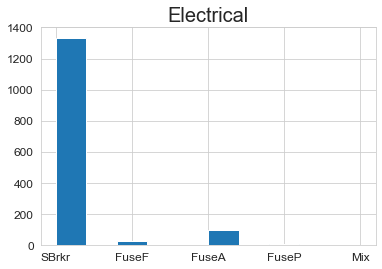

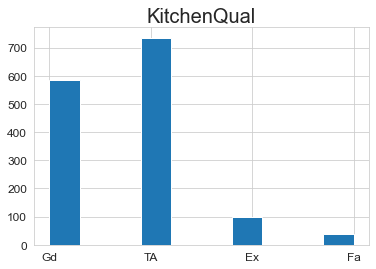

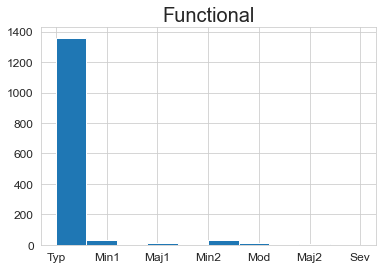

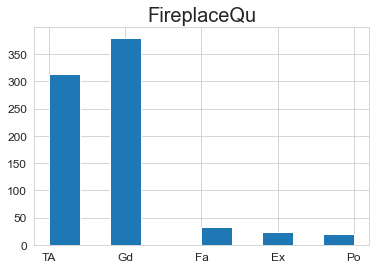

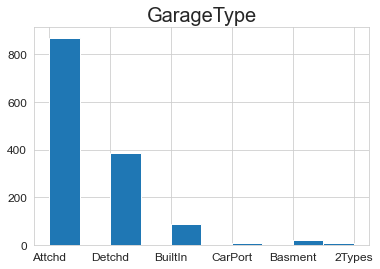

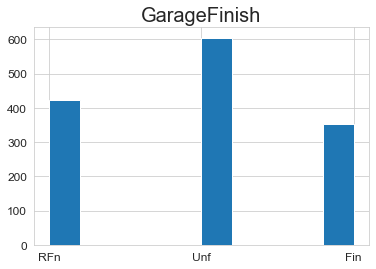

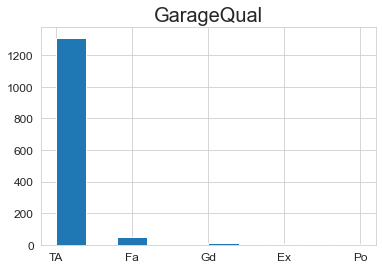

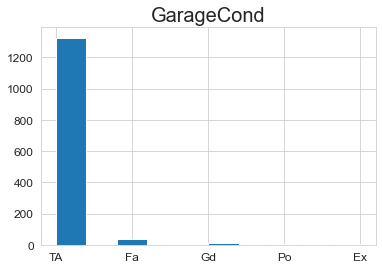

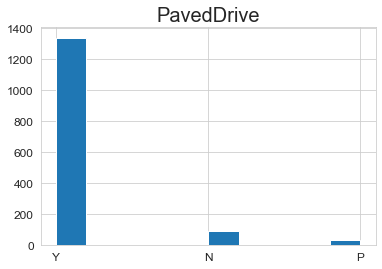

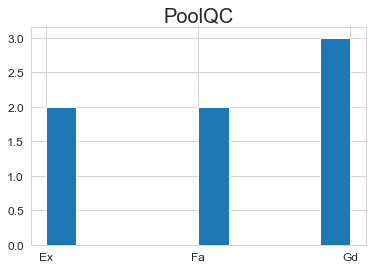

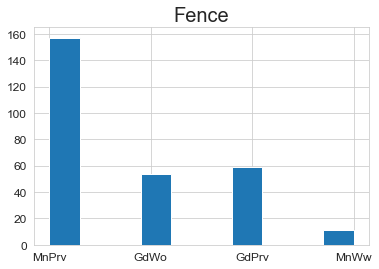

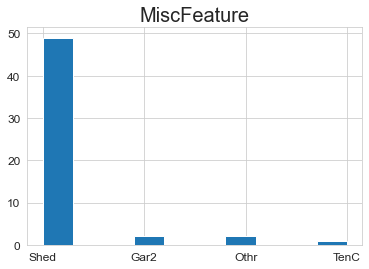

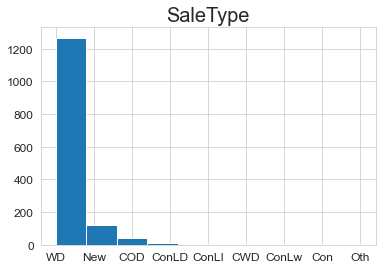

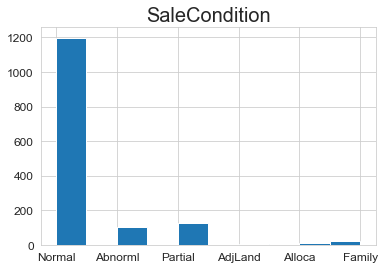

In [51]:
for c in cat_features:
    plt.figure()
    df[c].hist(xlabelsize=12, ylabelsize=12)
    plt.title(f'{c}', fontsize=20)
    plt.show();

In [52]:
# need to check condition 1 + value

## Feature Correlation

In [53]:
cm = df.iloc[:,1:].corr()[df.iloc[:,1:].corr().abs().ge(.5)]

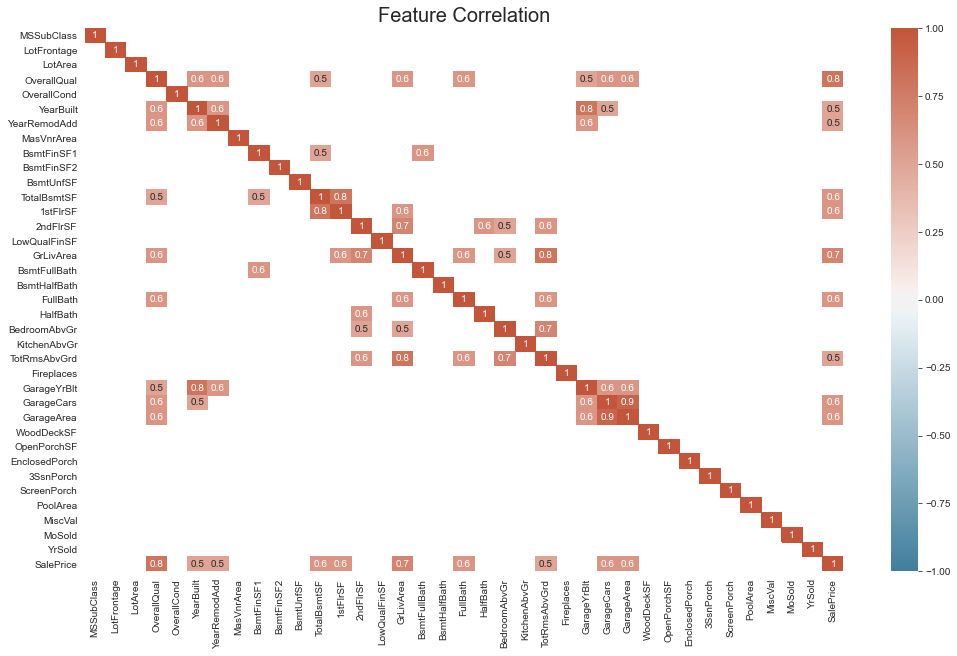

In [54]:
plt.figure(figsize=(17, 10))
sns.heatmap(cm.round(1), vmin=-1, vmax=1, annot=True, cmap=sns.diverging_palette(230, 20, as_cmap=True))
plt.title('Feature Correlation', fontsize=20)
plt.show;

In [55]:
# look for distribution in train/test

In [56]:
# check misc features (with/without)

df[['MiscFeature', 'MiscVal']].dropna()

,MiscFeature,MiscVal
5,Shed,700
7,Shed,350
16,Shed,700
17,Shed,500
51,Shed,400
84,Shed,700
95,Shed,480
98,Shed,400
99,Shed,400
106,Shed,450


## Preparing File for Linear Regression

In [57]:
# alternatively

df.drop(columns=['MiscFeature', 'MiscVal'], inplace=True)

In [60]:
# # filling in missing values

# # LotFrontage depends on configuration (inside, corner etc)
# df['LotFrontage'] = (df['LotFrontage']
#                      .fillna(df.groupby('LotConfig')['LotFrontage'].transform('mean').round())
#                     )
# # creating a new category: not applicable ('NA')
not_appl_cols = [
    'Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 
    'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'PoolQC', 'Fence',
    'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'
]
# df[not_appl_cols] = df[not_appl_cols].fillna('NA')

# # 0 for NA
# zero_cols = [
#     'MasVnrArea', 'GarageYrBlt'
# ]
# df[zero_cols] = df[zero_cols].fillna(0)

# # filling with most common
# df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0])

# # MiscFeature & MiscVal dropping (only have values for 3.7% dataset)
# df.drop(columns=['MiscFeature', 'MiscVal'], inplace=True)

In [62]:
df.drop(columns=not_appl_cols, inplace=True)

In [64]:
df = df.dropna()

In [65]:
# no more missing values

assert df.isnull().sum().sum() == 0

In [66]:
df.shape

(1120, 66)

In [67]:
# dropping col that we created + highly correlated cols

cols_to_drop = [
    'SaleDate', 'TotalBsmtSF', 'GarageYrBlt', 'GarageArea'
]

df.drop(columns=cols_to_drop, inplace=True)

In [68]:
# turn categorical features into numeric

for c in df.select_dtypes(include='object').columns:
    df[c] = df[c].astype('category').cat.codes

In [69]:
df.dtypes.unique()

array([dtype('int64'), dtype('int8'), dtype('float64')], dtype=object)

In [70]:
# # removing outliers in target

# df = df[df['SalePrice'] <= 200000]
# df.shape

In [71]:
# split to features and target

X = df.copy()
y = X.pop('SalePrice')

In [72]:
y = y.values.reshape(-1, 1)

In [83]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# y_scaled = scaler.fit_transform(y)

In [84]:
# train-test split

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=.3, random_state=42)

In [85]:
model = LinearRegression()
model.fit(X_train, y_train)
preds = model.predict(X_val)

In [86]:
# assessment
mse = mean_squared_error(y_val, preds)
r2 = r2_score(y_val, preds)
print(f'MSE: {mse :,.2f} / RMSE: {np.sqrt(mse) :,.2f} / R2: {r2 :,.2f}')

MSE: 2,463,647,411.57 / RMSE: 49,635.14 / R2: 0.67


In [87]:
# # inverse scaling
# preds = scaler.inverse_transform(preds_scaled)
# true_y = scaler.inverse_transform(y_val)

In [88]:
# fitting linear regression

model = LinearRegression()
mse_across_folds = []
r2_across_folds = []

kf = KFold(n_splits=10, random_state=None, shuffle=False)
for i, (train_idx, test_idx) in enumerate(kf.split(X_scaled)):
    X_train, y_train = X_scaled[train_idx], y[train_idx]
    X_val, y_val = X_scaled[test_idx], y[test_idx]
    model.fit(X_train, y_train)
    fold_preds = model.predict(X_val)
    fold_mse = mean_squared_error(y_val, fold_preds)
    fold_r2 = r2_score(y_val, fold_preds)
    print(f'- Fold {i}. MSE: {fold_mse :,.2f} / RMSE: {np.sqrt(fold_mse) :,.2f} / R2: {fold_r2 :,.2f}')
    mse_across_folds.append(fold_mse)
    r2_across_folds.append(fold_r2)

print(f'Mean MSE: {np.mean(mse_across_folds) :,.2f}')
print(f'Mean RMSE: {np.sqrt(mse_across_folds).mean() :,.2f}')
print(f'Mean R2: {np.mean(r2_across_folds) :,.2f}')

- Fold 0. MSE: 679,603,589.65 / RMSE: 26,069.21 / R2: 0.87
- Fold 1. MSE: 692,658,332.69 / RMSE: 26,318.40 / R2: 0.90
- Fold 2. MSE: 820,631,058.66 / RMSE: 28,646.66 / R2: 0.88
- Fold 3. MSE: 2,086,459,951.09 / RMSE: 45,677.78 / R2: 0.70
- Fold 4. MSE: 1,710,277,078.91 / RMSE: 41,355.50 / R2: 0.83
- Fold 5. MSE: 1,002,190,675.87 / RMSE: 31,657.40 / R2: 0.85
- Fold 6. MSE: 924,848,168.67 / RMSE: 30,411.32 / R2: 0.85
- Fold 7. MSE: 955,201,319.36 / RMSE: 30,906.33 / R2: 0.82
- Fold 8. MSE: 4,787,607,151.00 / RMSE: 69,192.54 / R2: 0.43
- Fold 9. MSE: 728,974,912.29 / RMSE: 26,999.54 / R2: 0.85
Mean MSE: 1,438,845,223.82
Mean RMSE: 35,723.47
Mean R2: 0.80


In [89]:
test = pd.read_csv('./data/test.csv')
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [94]:
test.isnull().sum()[test.isnull().sum().gt(0)][:20]

MSZoning           4
LotFrontage      227
Alley           1352
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        16
MasVnrArea        15
BsmtQual          44
BsmtCond          45
BsmtExposure      44
BsmtFinType1      42
BsmtFinSF1         1
BsmtFinType2      42
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
dtype: int64